# Tutorial, python acoustics

---

## Python install via conda

Download Miniconda2 from the [conda website](https://conda.io/miniconda.html)
(Python 2.7) and install:
```
bash Miniconda2-latest-Linux-x86_64.sh
bash
conda update conda
conda create --name acoustic python
source activate acoustic
conda install numpy -c conda-forge
conda install scipy -c conda-forge
conda install matplotlib -c conda-forge
conda install jupyter -c conda-forge
```

---

## Download other useful libraries (for this tutorial and examples)


```
git clone 
git clone 
```


In [1]:
# import libraries

import numpy as np
import scipy
import matplotlib.pyplot as plt
from wave import open as open_wave

# The doc for these libraries are easily found by googling them.
# We'll use the wave library to read .wav files which is a built-in library, see:
#   https://docs.python.org/2/library/wave.html


---

## Open and read a wave file


In [ ]:

# from ThinkDSP/code/thinkdsp.py :
def read_wave(filename='sound.wav'):
    """Reads a wave file.
    filename: string
    returns: Wave
    """
    fp = open_wave(filename, 'r')

    nchannels = fp.getnchannels()
    nframes = fp.getnframes()
    sampwidth = fp.getsampwidth()
    framerate = fp.getframerate()
    
    z_str = fp.readframes(nframes)
    
    fp.close()

    dtype_map = {1:np.int8, 2:np.int16, 3:'special', 4:np.int32}
    if sampwidth not in dtype_map:
        raise ValueError('sampwidth %d unknown' % sampwidth)
    
    if sampwidth == 3:
        xs = np.fromstring(z_str, dtype=np.int8).astype(np.int32)
        ys = (xs[2::3] * 256 + xs[1::3]) * 256 + xs[0::3]
    else:
        ys = np.fromstring(z_str, dtype=dtype_map[sampwidth])

    # if it's in stereo, just pull out the first channel
    if nchannels == 2:
        ys = ys[::2]

    #ts = np.arange(len(ys)) / framerate
    wave = Wave(ys, framerate=framerate)
    wave.normalize()
    return wave


In [1]:
# download wave file

# open wave file

# play wave file


---

## Compute spectra and spectrogram


In [ ]:
# compute spectrum and plot it

# compute spectrogram and plot it


---

## Compute convolution


In [ ]:
# compute convolution with another signal


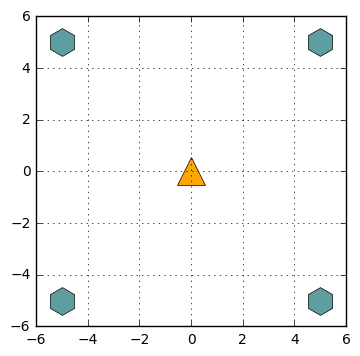

In [2]:

# sound speed
c = 1500. # m/s

# class for sources
class source(object):
    ''' A source object '''
    def __init__(self, x, y, e_i=100., label=''):
        ''' Input parameters:
        x,y  - horizontal position in meters
        e_i - uncertainty on the distance estimation
        label - a label for the source
        '''
        self.x=x
        self.y=y
        self.e_i=e_i
        self.tau_i=None
        self.label = 'source '+label
        
    def plot(self):
        plt.plot(self.x/1.e3,self.y/1.e3, color='cadetblue', marker='h', markersize=20, label=self.label)
    
    def set_tau_i(self,obj):
        self.tau_i = np.sqrt((self.x-obj.x)**2+(self.y-obj.y)**2)/c
    
    def get_epsilon(self,Np=1):
        epsilon = np.random.randn(Np)*self.e_i
        return epsilon
    

# class for receivers:
class receiver(object):
    ''' A receiver object '''
    def __init__(self, x, y, e_t=1., label=''):
        ''' Input parameters:
        x,y  - horizontal position in meters
        e_t - uncertainty on the clock drift in seconds
        label - a label for the receiver
        '''
        self.x=x
        self.y=y
        self.e_t=e_t 
        self.label = 'receiver '+label        

    def plot(self):
        plt.plot(self.x/1.e3,self.y/1.e3, color='orange', marker='^', markersize=20, label=self.label)



        
### create an ensemble of sources

# square formation:
dx=10. *1.e3 # in meters
sources=[]
sources.append(source(-dx*.5,-dx*.5))
sources.append(source(dx*.5,-dx*.5))
sources.append(source(dx*.5,dx*.5))
sources.append(source(-dx*.5,dx*.5))

# triangle formation:
#dx=10. *1.e4 # in meters
#sources=[]
#sources.append(source(-dx*.5,-dx.*5))
#sources.append(source(dx,-dx*.5))
#sources.append(source(0.,dx*.5))


### init a receiver
r=receiver(0. *1.e3,0. *1.e3)



### plot
plt.figure()
ax=plt.subplot(111)
[s.plot() for s in sources]
r.plot()
ax.grid()
#ax.set_xlim([-1.,21.])
#ax.set_ylim([-1.,11.])
ax.set_aspect('equal')
plt.show()




In [3]:
### Monte-Carlo simulation of geolocations

# compute theoretical (true) arrival time based on distances
[s.set_tau_i(r) for s in sources]

# set t0 and clock offset
t0 = 0.
r.clock_offset = 1.  # in seconds, >0 when the receiver clock is ahead


# convert data into numpy arrays
xi = np.array([s.x for s in sources])
yi = np.array([s.y for s in sources])
ei = np.array([s.e_i for s in sources])


### loop over each ensemble member
Np=1000 # number of members
x=np.zeros(Np)
y=np.zeros(Np)
t1_received=np.zeros(Np)
t1_adjusted=np.zeros(Np)
for i in xrange(Np):
    # compute perturbed arrival times
    ti = t0 + np.array([s.tau_i+s.get_epsilon()/c for s in sources])[:,0] + r.clock_offset
    t1_received[i] = ti[0]
    taui = ti - ti[0]
    #
    fun = lambda (x,y,t1): np.sum( ( np.sqrt((x-xi)**2 + (y-yi)**2) - c*(taui + t1 - t0) )**2 /ei**2 )
    res = minimize(fun,(0.,0.,0.))
    #
    x[i]=res.x[0]
    y[i]=res.x[1]
    t1_adjusted[i]=res.x[2]
    


mean(x) - x_true = 0.9 m
mean(y) - y_true = 3.2 m
sqrt(mean(||x-x_true||^2)) = 102.1 m
mean(t1_received) = 5.7 s
mean(t1_adjusted) = 4.7 s
mean(clock offset) = 1.0 s


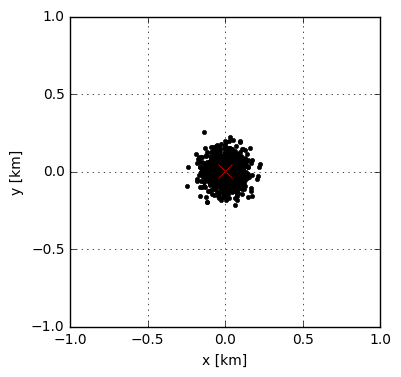

In [4]:
### compute the mean clock offset and print out useful info
clock_offset = t1_received.mean() - t1_adjusted.mean()

print 'mean(x) - x_true = %.1f m' %(x.mean()-r.x)
print 'mean(y) - y_true = %.1f m' %(y.mean()-r.y)
print 'sqrt(mean(||x-x_true||^2)) = %.1f m' % np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) )
print 'mean(t1_received) = %.1f s' %(t1_received.mean())
print 'mean(t1_adjusted) = %.1f s' %(t1_adjusted.mean())
print 'mean(clock offset) = %.1f s' %(t1_received.mean()-t1_adjusted.mean())



###  plot geolocations
ax=plt.subplot(111)
[s.plot() for s in sources]
r.plot()

ax.plot(x/1.e3,y/1.e3,'k.')
ax.plot(x.mean()/1.e3,y.mean()/1.e3,'x',color='red',markersize=10)

dxs=1000. /1.e3
ax.set_xlim([r.x/1e3-dxs,r.x/1e3+dxs])
ax.set_ylim([r.y/1e3-dxs,r.y/1e3+dxs])
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.grid()
ax.set_aspect('equal')
plt.show()

In [6]:
#
# Compute now a map of errors
#

# target grid
Lx = 20.* 1.e3
Ly=Lx
xt = np.linspace(-Lx/2.,Lx/2.,30)
yt = np.linspace(-Ly/2.,Ly/2.,30)
Xt, Yt = np.meshgrid(xt,yt)

# init a receiver
r=receiver(5.e3,5.e3)
r.clock_offset = 1.  # in seconds, >0 when the receiver clock is ahead

def run_sim(rx,ry):
    # Monte Carlo ensemble numbers
    Np=100
    # update the receiver position
    r.x = rx
    r.y = ry
    # compute theoretical (true) arrival time based on distances
    [s.set_tau_i(r) for s in sources]
    #
    x=np.zeros(Np)
    y=np.zeros(Np)
    t1_received=np.zeros(Np)
    t1_adjusted=np.zeros(Np)
    for i in xrange(Np):
        # perturb arrival times
        ti = t0 + np.array([s.tau_i+s.get_epsilon()/c for s in sources])[:,0] + r.clock_offset
        t1_received[i] = ti[0]
        taui = ti - ti[0]
        #
        fun = lambda (x,y,t1): np.sum( ( np.sqrt((x-xi)**2 + (y-yi)**2) - c*(taui + t1 - t0) )**2/ei**2 )
        res = minimize(fun,(0.,0.,0.))
        #
        ax.plot(res.x[0]/1.e3,res.x[1]/1.e3,'k.')
        x[i]=res.x[0]
        y[i]=res.x[1]
        t1_adjusted[i]=res.x[2]
    # compute the mean of the error on the receiver position
    drms = np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) )
    # compute the clock offset
    clock_offset = t1_received.mean() - t1_adjusted.mean()
    return drms, x.mean()-r.x, y.mean()-r.y, clock_offset


drms = np.zeros_like(Xt)
xbias = np.zeros_like(Xt)
ybias = np.zeros_like(Xt)
clock_offset = np.zeros_like(Xt)
for i, j in np.ndindex(Xt.shape):
    drms[i,j], xbias[i,j], ybias[i,j], clock_offset[i,j] = run_sim(Xt[i,j],Yt[i,j])


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


min(drms) = 91.393791


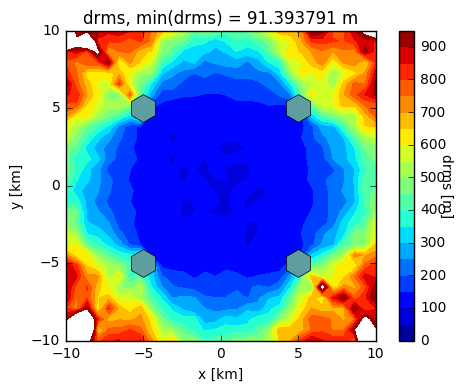

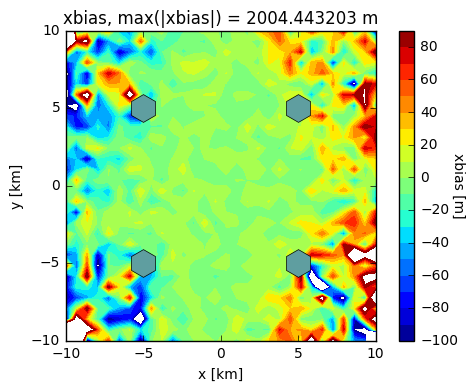

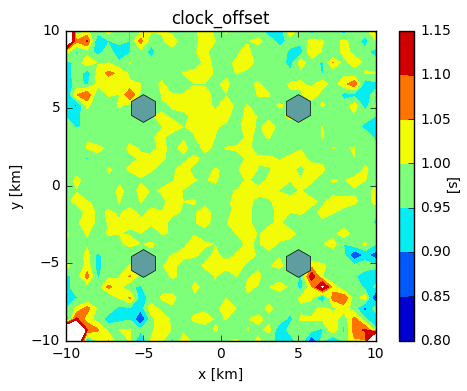

In [23]:

#
print 'min(drms) = %f' % drms.min()



### plot the error map

ax=plt.subplot(111)
lvls=np.arange(0.,1.e3,50.)
plt.contourf(Xt/1.e3,Yt/1.e3,drms,lvls)
cbar = plt.colorbar()
cbar.ax.set_ylabel('drms [m]', rotation=270)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('drms, min(drms) = %f m' % drms.min())
ax.set_aspect('equal')
plt.show()


### bias in x direction
ax=plt.subplot(111)
lvls=np.arange(-1.e2,1.e2,1.e1)
plt.contourf(Xt/1.e3,Yt/1.e3,xbias,lvls)
cbar = plt.colorbar()
cbar.ax.set_ylabel('xbias [m]', rotation=270)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('xbias, max(|xbias|) = %f m' % np.abs(xbias).max())
ax.set_aspect('equal')
plt.show()


### clock offset
ax=plt.subplot(111)
lvls=np.arange(.8,1.2,.05)
plt.contourf(Xt/1.e3,Yt/1.e3,clock_offset,lvls)
cbar = plt.colorbar()
cbar.ax.set_ylabel('[s]', rotation=270)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('clock_offset')
ax.set_aspect('equal')
plt.show()

